# Modelling

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import math
import seaborn as sns

from sklearn import metrics
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, f1_score, plot_precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import RobustScaler

import xgboost as xgb

from imblearn.over_sampling import SMOTE

import shap

# import warnings filter
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Set max rows and columns display
pd.set_option("display.max_columns", None)

---

In [3]:
# read in csv file
train = pd.read_csv('../00-Datasets/feature_selected.csv')

In [4]:
train.head()

,latitude,longitude,wnvpresent,year,month,week,day,tmax,tmax_lag9,tmin,tmin_lag9,tavg,tavg_lag9,dewpoint,dewpoint_lag9,wetbulb,wetbulb_lag9,heat,heat_lag9,cool,cool_lag9,sunrise,sunrise_lag9,sunset,sunset_lag9,preciptotal,preciptotal_lag9,stnpressure,stnpressure_lag9,sealevel,sealevel_lag9,resultspeed,resultspeed_lag9,resultdir,resultdir_lag9,avgspeed,avgspeed_lag9,favourablebreedingtemp,favourablebreedingtemp_lag9,r_humid,r_humid_lag9,daylength_hour,daylength_hour_lag9,nightlength_hour,nightlength_hour_lag9,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_others,trap_T001,trap_T002,trap_T003,trap_T004,trap_T005,trap_T006,trap_T007,trap_T008,trap_T009,trap_T011,trap_T012,trap_T013,trap_T014,trap_T015,trap_T016,trap_T017,trap_T018,trap_T019,trap_T025,trap_T027,trap_T028,trap_T030,trap_T031,trap_T033,trap_T034,trap_T035,trap_T036,trap_T037,trap_T039,trap_T040,trap_T043,trap_T044,trap_T045,trap_T046,trap_T047,trap_T048,trap_T049,trap_T050,trap_T051,trap_T054,trap_T054C,trap_T060,trap_T061,trap_T062,trap_T063,trap_T065,trap_T066,trap_T067,trap_T069,trap_T070,trap_T071,trap_T072,trap_T073,trap_T074,trap_T075,trap_T076,trap_T077,trap_T078,trap_T079,trap_T080,trap_T081,trap_T082,trap_T083,trap_T084,trap_T085,trap_T086,trap_T088,trap_T089,trap_T090,trap_T091,trap_T092,trap_T094,trap_T094B,trap_T095,trap_T096,trap_T097,trap_T099,trap_T100,trap_T102,trap_T103,trap_T107,trap_T114,trap_T115,trap_T128,trap_T129,trap_T135,trap_T138,trap_T141,trap_T142,trap_T143,trap_T144,trap_T145,trap_T146,trap_T147,trap_T148,trap_T149,trap_T150,trap_T151,trap_T152,trap_T153,trap_T154,trap_T155,trap_T156,trap_T157,trap_T158,trap_T159,trap_T160,trap_T161,trap_T162,trap_T200,trap_T206,trap_T209,trap_T212,trap_T215,trap_T218,trap_T219,trap_T220,trap_T221,trap_T222,trap_T223,trap_T224,trap_T225,trap_T226,trap_T227,trap_T228,trap_T229,trap_T230,trap_T231,trap_T232,trap_T233,trap_T235,trap_T236,trap_T237,trap_T238,trap_T900,trap_T903
0,41.954690,-87.800991,0,2007,5,22,29,88,69.0,60,43.0,74,56.0,58,40.0,65,44.0,0,9.0,9,0.0,421,427.0,1917,1909.0,0.0,0.07,29.39,29.38,30.11,30.11,5.8,10.4,18,4.0,6.5,10.7,1,0.0,57,55.0,15.0,15.0,9.0,9.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,41.954690,-87.800991,0,2007,5,22,29,88,69.0,60,43.0,74,56.0,58,40.0,65,44.0,0,9.0,9,0.0,421,427.0,1917,1909.0,0.0,0.07,29.39,29.38,30.11,30.11,5.8,10.4,18,4.0,6.5,10.7,1,0.0,57,55.0,15.0,15.0,9.0,9.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,41.994991,-87.769279,0,2007,5,22,29,88,69.0,60,43.0,74,56.0,58,40.0,65,44.0,0,9.0,9,0.0,421,427.0,1917,1909.0,0.0,0.07,29.39,29.38,30.11,30.11,5.8,10.4,18,4.0,6.5,10.7,1,0.0,57,55.0,15.0,15.0,9.0,9.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [5]:
train.shape

(10506, 185)

## Pre-Processing

### Train-Test-Split
Dataset will be split into train and test for model evaluation. Cross validation will also be done on the train split to further test robustness of model.

In [6]:
y = train['wnvpresent']
X = train.drop(columns=['wnvpresent'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [8]:
y_train.value_counts()

0    7466
1     413
Name: wnvpresent, dtype: int64

## Models
We will define the baseline model and evaluate other built models against each other based on their recall scores. The recall score is a commonly used measure of model performance that weights the count of predicted true positives out of all the actual positive values. 

Feature variables will also be scaled as part of the model building pipeline to improve model processing speed.

We are focused on being able to detect true positives so that actions can be taken to address the virus and its vectors effectively. Our cost benefit analysis will be presented in a later part to further illuminate the benefits and major potential cost reduction of such an approach.

### Resampling The Train Set (SMOTE)
Synthetic Minority Oversampling Technique (SMOTE) is a statistical technique used to increase the number of minority samples in imbalanced datasets in a random, balanced manner.

### Robust Scalar
Robust Scaler is a algorithms scale features that are robust to outliers <a href="https://machinelearninggeek.com/feature-scaling-minmax-standard-and-robust-scaler/"><sup>1</sup></a>. The reason for using this based on the EDA results that the presence of West Nile Virus in mosquitos is very low and it is like out of the norm.

### StratifiedKFold
Stratified k-fold is the enhanced process of K-Fold cross-validation. K-fold cross-validation is the process where the whole data is splits into K-parts of equal size where each part is called K-fold. The difference between the stratified k-fold and normal k-fold lies in the word stratified. Meaning that stratified k-fold has additional parameter, which is having the same ratio of the target variable as the whole dataset. It is used for imbalanced dataset as the target varialbe is imbalanced, which means that the raio of the target variable will be the same throughout each split <a href="https://www.analyticsvidhya.com/blog/2021/11/top-7-cross-validation-techniques-with-python-code/"><sup>1</sup></a> . Therefore, this will be used in the later part for cross-vaildation. 

In [9]:
#for cross-val fold
stratified_kfold = StratifiedKFold(n_splits=10,shuffle=False)

### Scoring and Plotting Functions

In [10]:
def scoring(model, classifier_name, X_train, y_train, X_test, y_test):
    nl = '\n'
    
    print(f'{classifier_name} scores:')
    
    train_predict = model.predict(X_train)
    print(f'Train Recall Score: {recall_score(y_train, train_predict,average="weighted")}')
    
    test_predict = model.predict(X_test)
    print(f'Test Recall Score: {recall_score(y_test, test_predict,average="weighted")}')
    
    return test_predict

In [11]:
# sns colour palette
palette = sns.cubehelix_palette(as_cmap=True)

def subplot_matrix_roc(model, classifier_name, X_test, y_test):
    fig, ax= plt.subplots(1,2,figsize=(15,7))
    
    predictions = model.predict(X_test)
    
    # plot confusion matrix on left
    cm = confusion_matrix(y_test, predictions, labels=model.classes_)
    sns.heatmap(cm, annot=True, fmt='g', ax=ax[0], cmap=palette);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax[0].set_xlabel('Predicted labels');ax[0].set_ylabel('Actual labels'); 
    ax[0].set_title(f'Confusion Matrix for {classifier_name}'); 
    ax[0].xaxis.set_ticklabels(['WNV Absent', 'WNV Present']); ax[0].yaxis.set_ticklabels(['WNV Absent', 'WNV Present']);
#     ConfusionMatrixDisplay.from_predictions(y_test,predictions,ax=ax[0])
#     ax[0].set_title(f'{classifier_name} Confusion Matrix', fontsize=14, weight='bold')

    # plot roc curve on right
    # RocCurveDisplay.from_predictions(y_test,predictions,ax=ax[1])
    RocCurveDisplay.from_estimator(model,X_test,y_test,ax=ax[1])

    ax[1].set_title(f'{classifier_name} ROC Curve', fontsize=14, weight='bold')
    #plotting baseline
    ax[1].plot(
        np.linspace(0, 1, 200),
        np.linspace(0, 1, 200),
        label='Baseline',
        linestyle='--',
        color='red')
    ax[1].legend(loc='best',fontsize=13,)

    plt.tight_layout()

### Logistic Regression

In [12]:
log_pipe=imbpipeline(steps=[["smote",SMOTE()],
                              ['rs', RobustScaler()], 
                              ["log",LogisticRegression()]])

In [13]:
log_pipe.get_params()

{'memory': None,
 'steps': [['smote', SMOTE()],
  ['rs', RobustScaler()],
  ['log', LogisticRegression()]],
 'verbose': False,
 'smote': SMOTE(),
 'rs': RobustScaler(),
 'log': LogisticRegression(),
 'smote__k_neighbors': 5,
 'smote__n_jobs': None,
 'smote__random_state': None,
 'smote__sampling_strategy': 'auto',
 'rs__copy': True,
 'rs__quantile_range': (25.0, 75.0),
 'rs__unit_variance': False,
 'rs__with_centering': True,
 'rs__with_scaling': True,
 'log__C': 1.0,
 'log__class_weight': None,
 'log__dual': False,
 'log__fit_intercept': True,
 'log__intercept_scaling': 1,
 'log__l1_ratio': None,
 'log__max_iter': 100,
 'log__multi_class': 'auto',
 'log__n_jobs': None,
 'log__penalty': 'l2',
 'log__random_state': None,
 'log__solver': 'lbfgs',
 'log__tol': 0.0001,
 'log__verbose': 0,
 'log__warm_start': False}

In [14]:
log_pipe_params=[{'smote__n_jobs': [-1],
                  'smote__random_state': [42],
                  'log__random_state': [42],
                  'log__n_jobs': [-1],
                  'log__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                  'log__class_weight': ["balanced"]
                   }]

In [15]:
%%time
log_pipe_gridsearch = GridSearchCV(log_pipe,
                                       log_pipe_params,
                                       cv=stratified_kfold,
                                       verbose=0,
                                       scoring="recall",
                                       n_jobs=-1)

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 8.34 µs


In [16]:
%%time
# Fit the GridSearchCV object to the data.
log_result=log_pipe_gridsearch.fit(X_train, y_train);display(log_result)

/Users/mingming/miniforge3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mingming/miniforge3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

/Users/mingming/miniforge3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mingming/miniforge3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mingming/miniforge3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mingming/miniforge3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mingming/miniforge3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mingming/miniforge3/lib/python3.10/sit

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[['smote', SMOTE()],
                                       ['rs', RobustScaler()],
                                       ['log', LogisticRegression()]]),
             n_jobs=-1,
             param_grid=[{'log__class_weight': ['balanced'],
                          'log__n_jobs': [-1], 'log__random_state': [42],
                          'log__solver': ['newton-cg', 'lbfgs', 'liblinear',
                                          'sag', 'saga'],
                          'smote__n_jobs': [-1], 'smote__random_state': [42]}],
             scoring='recall')

CPU times: user 2.72 s, sys: 1.47 s, total: 4.19 s
Wall time: 10.5 s


In [17]:
%%time
display("The log best estimators are : ",log_result.best_estimator_)
display("The log best parameters are : ",log_result.best_params_)

'The log best estimators are : '

Pipeline(steps=[('smote', SMOTE(n_jobs=-1, random_state=42)),
                ('rs', RobustScaler()),
                ['log',
                 LogisticRegression(class_weight='balanced', n_jobs=-1,
                                    random_state=42, solver='saga')]])

'The log best parameters are : '

{'log__class_weight': 'balanced',
 'log__n_jobs': -1,
 'log__random_state': 42,
 'log__solver': 'saga',
 'smote__n_jobs': -1,
 'smote__random_state': 42}

CPU times: user 4.87 ms, sys: 1.43 ms, total: 6.29 ms
Wall time: 5.68 ms


In [18]:
log_predictions = scoring(log_result.best_estimator_, 'Logistic Regression', X_train, y_train, X_test, y_test)

Logistic Regression scores:
Train Recall Score: 0.7658332275669502
Test Recall Score: 0.7506661591168633


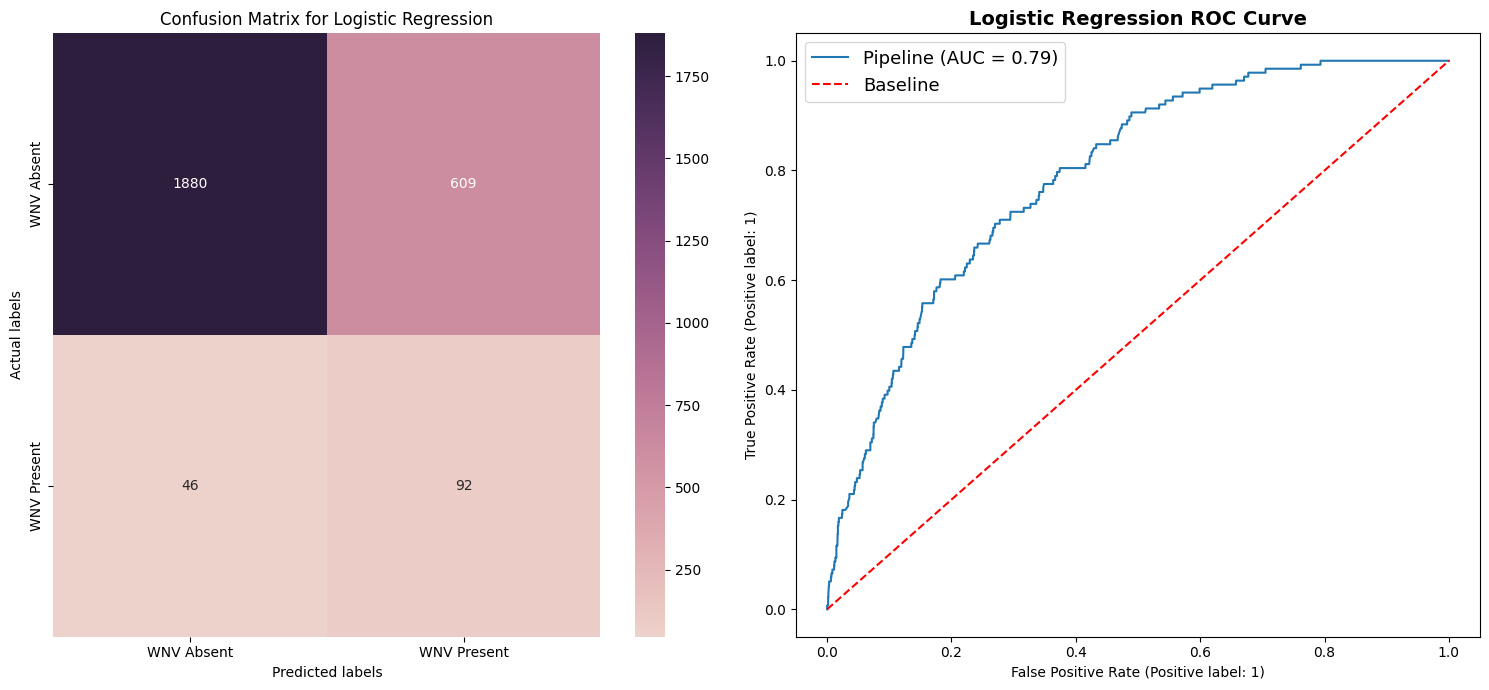

In [19]:
subplot_matrix_roc(log_result.best_estimator_, 'Logistic Regression', X_test, y_test)

### Random Forest Classifier

In [20]:
rf_pipe=imbpipeline(steps=[["smote",SMOTE()],
                            ['rs', RobustScaler()], 
                            ["rf",RandomForestClassifier()]])

In [21]:
rf_pipe.get_params()

{'memory': None,
 'steps': [['smote', SMOTE()],
  ['rs', RobustScaler()],
  ['rf', RandomForestClassifier()]],
 'verbose': False,
 'smote': SMOTE(),
 'rs': RobustScaler(),
 'rf': RandomForestClassifier(),
 'smote__k_neighbors': 5,
 'smote__n_jobs': None,
 'smote__random_state': None,
 'smote__sampling_strategy': 'auto',
 'rs__copy': True,
 'rs__quantile_range': (25.0, 75.0),
 'rs__unit_variance': False,
 'rs__with_centering': True,
 'rs__with_scaling': True,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': None,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [22]:
rf_pipe_params=[{'smote__n_jobs': [-1],#to use all cpu cores
                  'smote__random_state': [42],#set a number so that the result is repliicable
                  'rf__random_state': [42],
                 'rf__n_estimators': [60],
                 'rf__max_depth': [3],
                  'rf__n_jobs': [-1],
                   }]

In [23]:
%%time
rf_pipe_gridsearch = GridSearchCV(rf_pipe,
                                       rf_pipe_params,
                                       cv=stratified_kfold,
                                       verbose=0,
                                       scoring="recall",
                                       n_jobs=-1)

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 9.06 µs


In [24]:
%%time
# Fit the GridSearchCV object to the data.
rf_result=rf_pipe_gridsearch.fit(X_train, y_train);display(rf_result)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[['smote', SMOTE()],
                                       ['rs', RobustScaler()],
                                       ['rf', RandomForestClassifier()]]),
             n_jobs=-1,
             param_grid=[{'rf__max_depth': [3], 'rf__n_estimators': [60],
                          'rf__n_jobs': [-1], 'rf__random_state': [42],
                          'smote__n_jobs': [-1], 'smote__random_state': [42]}],
             scoring='recall')

CPU times: user 556 ms, sys: 332 ms, total: 888 ms
Wall time: 981 ms


In [25]:
%%time
display("The rf best estimators are : ",rf_result.best_estimator_)
display("The rf best parameters are : ",rf_result.best_params_)

'The rf best estimators are : '

Pipeline(steps=[('smote', SMOTE(n_jobs=-1, random_state=42)),
                ('rs', RobustScaler()),
                ['rf',
                 RandomForestClassifier(max_depth=3, n_estimators=60, n_jobs=-1,
                                        random_state=42)]])

'The rf best parameters are : '

{'rf__max_depth': 3,
 'rf__n_estimators': 60,
 'rf__n_jobs': -1,
 'rf__random_state': 42,
 'smote__n_jobs': -1,
 'smote__random_state': 42}

CPU times: user 5.7 ms, sys: 2.51 ms, total: 8.21 ms
Wall time: 4.75 ms


Random Forest scores:
Train Recall Score: 0.6865084401573803
Test Recall Score: 0.6802436239055958


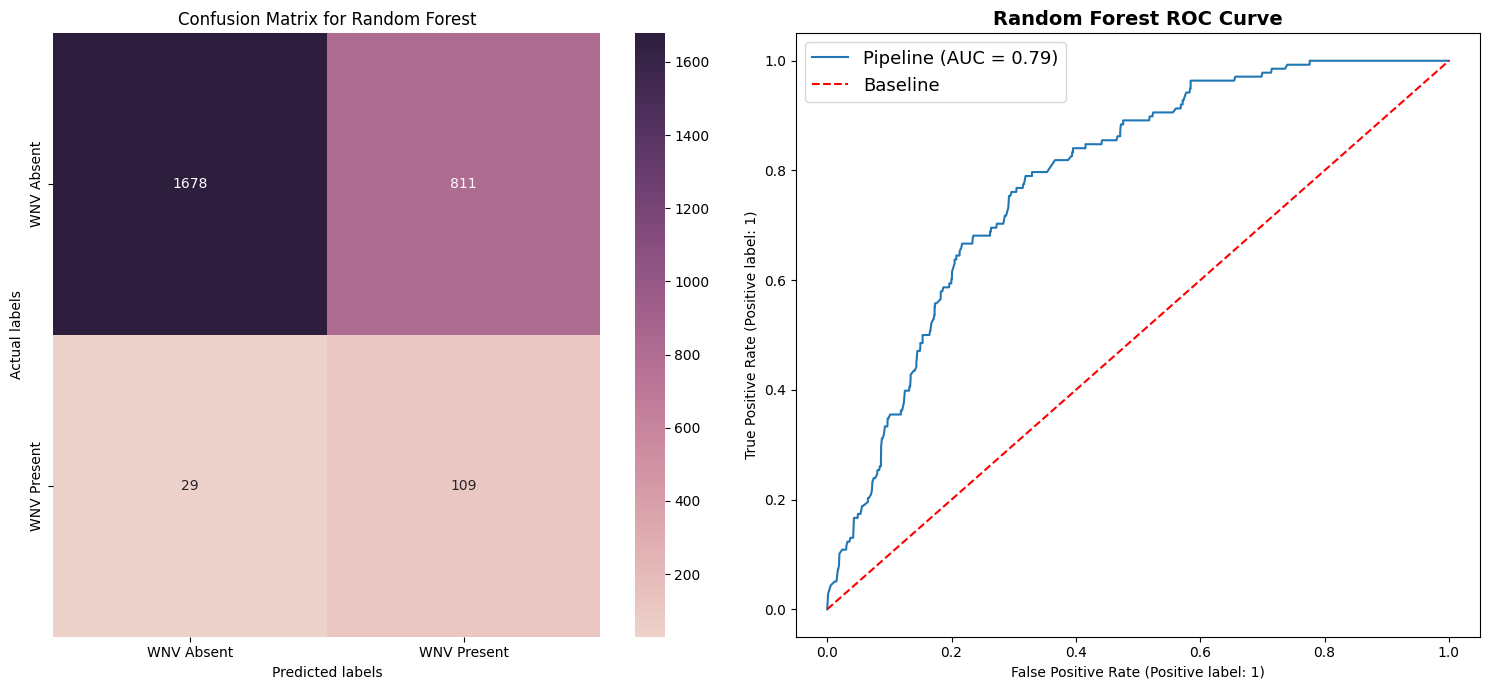

In [26]:
rf_predictions = scoring(rf_result.best_estimator_, 'Random Forest', X_train, y_train, X_test, y_test)

subplot_matrix_roc(rf_result.best_estimator_, 'Random Forest', X_test, y_test)

### AdaBoost

In [27]:
ada_pipe=imbpipeline(steps=[["smote",SMOTE()],
                            ['rs', RobustScaler()],
                            ["ada_classifier",AdaBoostClassifier()]])

In [28]:
ada_pipe.get_params()

{'memory': None,
 'steps': [['smote', SMOTE()],
  ['rs', RobustScaler()],
  ['ada_classifier', AdaBoostClassifier()]],
 'verbose': False,
 'smote': SMOTE(),
 'rs': RobustScaler(),
 'ada_classifier': AdaBoostClassifier(),
 'smote__k_neighbors': 5,
 'smote__n_jobs': None,
 'smote__random_state': None,
 'smote__sampling_strategy': 'auto',
 'rs__copy': True,
 'rs__quantile_range': (25.0, 75.0),
 'rs__unit_variance': False,
 'rs__with_centering': True,
 'rs__with_scaling': True,
 'ada_classifier__algorithm': 'SAMME.R',
 'ada_classifier__base_estimator': None,
 'ada_classifier__learning_rate': 1.0,
 'ada_classifier__n_estimators': 50,
 'ada_classifier__random_state': None}

In [29]:
#format : name of pipeline __ actual terms
ada_pipe_params = [{'smote__n_jobs': [-1],#to use all cpu cores
                    'smote__random_state': [42],#set a number so that the result is repliicable 
                    'ada_classifier__random_state': [42]}]

In [30]:
ada_pipe_gridsearch = GridSearchCV(ada_pipe, # What is the model we want to fit?
                                   ada_pipe_params, # What is the dictionary of hyperparameters?
                                   cv=stratified_kfold, # What number of folds in CV will we use?
                                   verbose=0,
                                   scoring="recall",
                                   n_jobs=-1)#to use all cpu cores

In [31]:
%%time
# Fit the GridSearchCV object to the data.
ada_result=ada_pipe_gridsearch.fit(X_train, y_train);

CPU times: user 1.56 s, sys: 394 ms, total: 1.96 s
Wall time: 3.97 s


In [32]:
ada_predictions = scoring(ada_result.best_estimator_, 'Adaboost', X_train, y_train, X_test, y_test)

Adaboost scores:
Train Recall Score: 0.8190125650463257
Test Recall Score: 0.8203273696231442


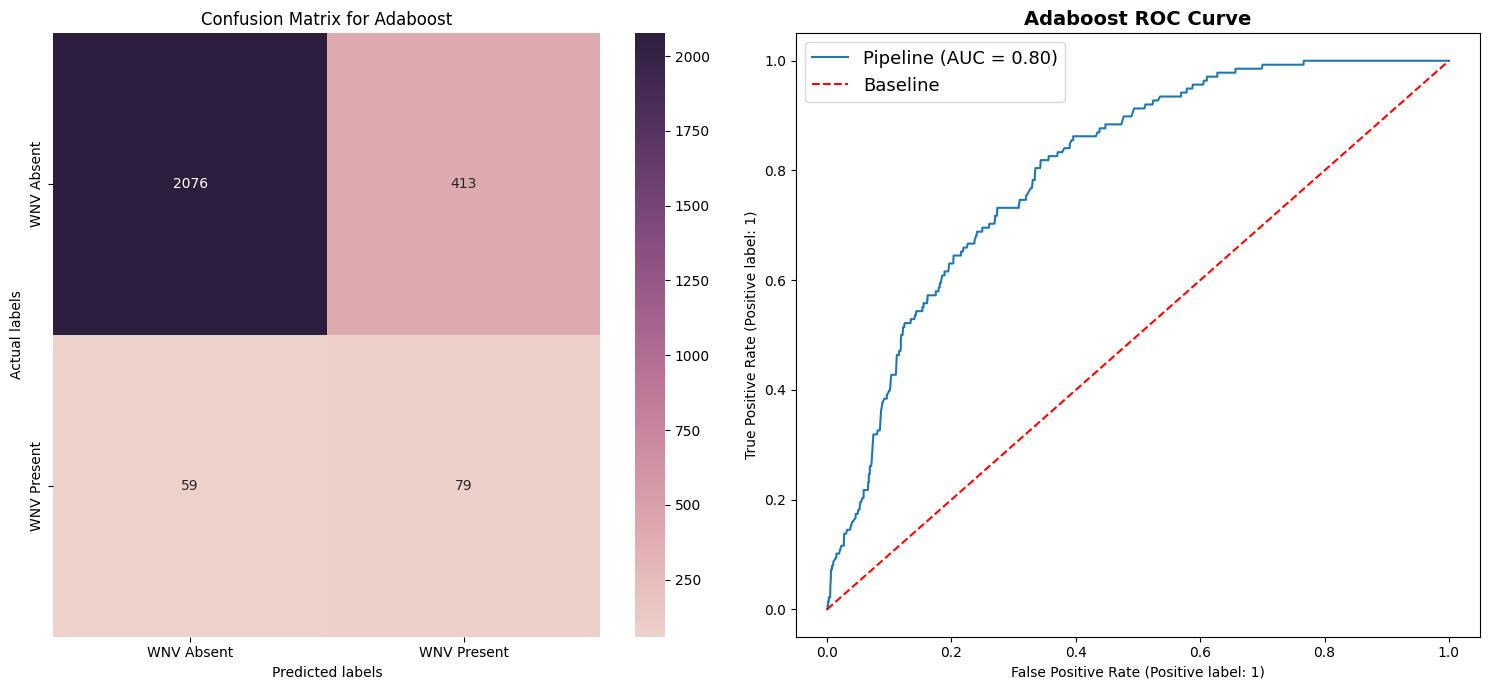

In [33]:
subplot_matrix_roc(ada_result.best_estimator_, 'Adaboost', X_test, y_test)

### XGBoost

In [34]:
xgboost_pipe=imbpipeline(steps=[["smote",SMOTE()],
                                ['rs', RobustScaler()],
                                ["xgboost_classifier",xgb.XGBClassifier()]])

In [35]:
xgboost_pipe.get_params()

{'memory': None,
 'steps': [['smote', SMOTE()],
  ['rs', RobustScaler()],
  ['xgboost_classifier',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, feature_types=None,
                 gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=None, max_bin=None,
                 max_cat_threshold=None, max_cat_to_onehot=None,
                 max_delta_step=None, max_depth=None, max_leaves=None,
                 min_child_weight=None, missing=nan, monotone_constraints=None,
                 n_estimators=100, n_jobs=None, num_parallel_tree=None,
                 predictor=None, random_state=None, ...)]],
 'verbose': False,
 'smote': SMOTE(),
 'rs': RobustScaler(),
 'xgboost_classifier': XGBClassifier(base_score=None

In [36]:
#pip parameter for gridsearch to optimise the best paramaters
xgboost_pipe_params = [{'smote__n_jobs': [-1],#to use all cpu cores
                        'smote__random_state': [42],#set a number so that the result is repliicable
                        'xgboost_classifier__random_state': [42],
                        'xgboost_classifier__n_jobs': [-1],
                        }]

In [37]:
xgboost_pipe_gridsearch = GridSearchCV(xgboost_pipe,
                                       xgboost_pipe_params,
                                       cv=stratified_kfold,
                                       verbose=0,
                                       scoring="recall",
                                       n_jobs=-1,)

In [38]:
%%time
# Fit the GridSearchCV object to the data.
xg_result=xgboost_pipe_gridsearch.fit(X_train, y_train);

CPU times: user 11.6 s, sys: 1.87 s, total: 13.5 s
Wall time: 17.5 s


In [39]:
xg_result.best_params_

{'smote__n_jobs': -1,
 'smote__random_state': 42,
 'xgboost_classifier__n_jobs': -1,
 'xgboost_classifier__random_state': 42}

In [40]:
xgb_predictions = scoring(xg_result.best_estimator_, 'xgboost', X_train, y_train, X_test, y_test)

xgboost scores:
Train Recall Score: 0.9525320472141134
Test Recall Score: 0.928054815378759


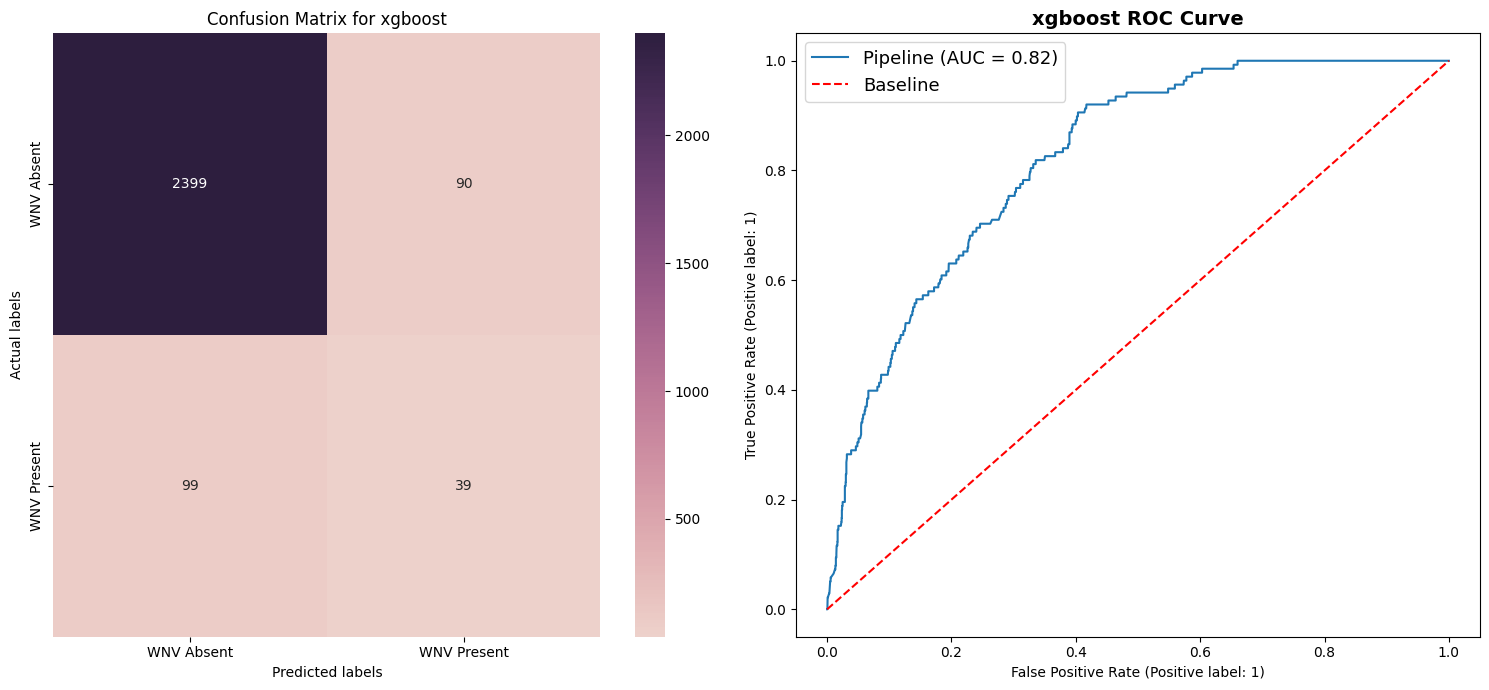

In [41]:
subplot_matrix_roc(xg_result.best_estimator_, 'xgboost', X_test, y_test)

## Evaluation

### Recall
Recall score is used as a measure of model performance in terms of correctly identifying the positive class out of all the actual positives. It is a more objective metric for imbalanced datasets and is also apt because of our greater interest in identifying true positives. <b>Mathematically, Recall is the number of relevant documents retrieved by a search divided by the total number of existing relevant documents.</b>

Optimizing for recall allows us to use the model to reduce the number of areas to spray while ensuring that we have a low miss rate on areas that actually have the West Nile Virus present. This is in line with the huge benefits that mosquito control has in terms of reducing various costs; from lost labour due to sick days up to massive medical costs and loss of life from potentially serious complications.

The table shown below shows the recall scores attained by each model, with Random Forest emerging triumphant over the others in terms of test recall score. Random Forest cleared the benchmark KNN model by a decent margin as well. While the other models seemed to perform better in train and cross validation, their performance dips sorely on the test set, suggesting gross overfitting.

|Model|Train Recall(%)|Test Recall(%)|
|:---:|:---:|:---:|
|Logistic Regression (baseline)|76.58|75.07|
|||||||
|Random Forest|68.65|68.02|
|||||||
|AdaBoost|81.90|82.03|
|||||||
|**XGBoost**|**95.25**|**92.81**|

## Kaggle
In line with the project requirements we will be predicting on the test dataset provided and submitting it in the format specified by Kaggle.

In [42]:
# load in test
test = pd.read_csv('../00-Datasets/test_prepped.csv')

In [43]:
test.shape

(116293, 185)

In [44]:
kaggle_test = test.drop('id', axis=1)

In [45]:
kaggle_test = kaggle_test[list(X.columns)] 

In [46]:
pred = xg_result.best_estimator_.predict(kaggle_test)
pred

array([0, 0, 0, ..., 0, 0, 0])

In [47]:
submission_test = pd.DataFrame({'ID': test.id, 'WnvPresent': pred})
print(submission_test.shape)
print(submission_test.head())

(116293, 2)
   ID  WnvPresent
0   1           0
1   2           0
2   3           0
3   4           0
4   5           0


In [48]:
submission_test.groupby('WnvPresent').count()

,ID
WnvPresent,
0,115521
1,772


In [49]:
submission_test.to_csv('../00-Datasets/test_sub.csv', index=False)

## Cost Benefit Analysis

---

### Background

In the continental United States, West Nile Virus (WNV) is the most common form of mosquito-borne disease. It is spread to people via the bite of an infected mosquito, and is as such much more prevalent during mosquito season which starts in the summer and continues through fall. This is unsurprisingly likely due to greater presence of its primary vector, the culex mosquito, during this period of time. There are currently **no vaccines to prevent WNV nor medications available to treat it**. 

Fortunately, most people infected with WNV do not experience any major symptoms. 1 in 5 infected however, do develop a fever among other symptoms such as joint pain and about 1 out of 150 infected develop a serious, sometimes fatal, illness.<a href="https://www.cdc.gov/westnile/index.html#:~:text=There%20are%20no%20vaccines%20to,serious%2C%20sometimes%20fatal%2C%20illness."><sup>1</sup></a>

---
### Existing Efforts

The CDPH Environmental Health program has been performing targeted insecticide spraying of adult mosquitoes (adulticiding) from July through late August. The brand of adulticide used is Zenivex® and this is used at a rate of 1.5 fluid ounces per acre<a href="https://abc7chicago.com/archive/9206273/"><sup>2</sup></a>.

Our exploratory data analysis also suggest that spraying works to reduce incidence of WNV, likely through the mechanism of reducing the number of mosquitoes in an area.

---
### Implementation Costs
**Direct Cost: Cost of Adulticide** 

Zenivex costs \$299.80/gl.<a href="https://www.gfmosquito.com/wp-content/uploads/2017/07/2017-ND-Mosq.-Control-Quotes-Tabulation.pdf"><sup>3</sup></a> This translates to a cost of \$3.51 per acre, scaling up to **$526,851** if applied throughout Chicago (150,100 acres).

**Indirect Cost: Environmental Concerns**

While people may be concerned about the environmental and health impact of mosquito control, pesticides and their labeling are constantly under review and require approval from the US Environmental Protection Agency (USEPA) before use. This is done to protect public health and further ensures that application methods minimize the risk of human exposure as well as adverse environmental effects. In fact, there is generally no need to relocate during mosquito control fogging<a href="https://dph.illinois.gov/topics-services/environmental-health-protection/structural-pest-control/mosquito-spray-faqs.html"><sup>4</sup></a>. Potential health and environmental costs are as such minimal.

---
### Implementation Benefits
**Reduction in Medical Costs and Loss of Productivity**

The median medical cost for a patient with WNV non-neuroinvasive disease (vanilla WNV disease) was \\$4,467 while the median cost for a patient with acute flaccid paralysis (serious complication) was \$20,774<a href="https://www.ajtmh.org/view/journals/tpmd/90/3/article-p402.xml"><sup>5</sup></a> in the United States. Majority of the total costs were incurred as hospital charges.

On a larger scale, extrapolated findings of a study on 2003 WNV data estimates that hospitalized cases of WNV disease have an **annual burden of \$56 million** in the United States<a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3945683/"><sup>6</sup></a>. Long-term direct and indirect medical costs after the initial illness can be extremely costly, depending on the severity of the illness and complications. While only a small subset of patients do end up with serious conditions, ranging from meningitis to acute flaccid paralysis, the costs to these individuals can easily runup to an amount much larger than the initial illness and hospitalization<a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3945683/"><sup>7</sup></a>.

This also draws down on available healthcare resources and is not an ideal situation to be in for an entire 5-month season.

**Preventing Proliferation of Disease Vectors**

While Culex mosquitoes are unable to fly far and only 5.2% of populations actually carry WNV, letting them breed and feed freely during the peak season is a dangerous game to play. Most mosquito-borne diseases proliferate with increased mosquito count and host-vector contact, which implies exponentiation of WNV presence with increased host & vector density. Keeping mosquito populations low, especially in dense and urbanized areas is also an effective way to prevent further spread and maintenance of disease hotspots.

---
### Analysis

Taking into consideration the various costs and benefits of an effective spraying plan, the direct net benefits alone appear to amount in the millions. Additionally, indirect benefits such as peace of mind are hard to quantify but equally important. Constantly getting bitten by mosquitoes over 5 months isn't the most enjoyable experience either.

---
### Further Cost Savings

In its current iteration, the seasonal mosquito spraying program in Chicago is already highly beneficial, particularly when compared to its cost. However, spraying efforts can be further streamlined to reduce direct costs.

Rather than the current spray and pray method, using our model as a guide to decide on spraying areas on demand can help to reduce costs by preventing overspraying. A Recall score of 0.80 implies that the model is quite capable in ensuring that areas with WNV are not missed. While the model isn't particularly high on precision, the extra cost of a false positive (extra spraying) is much lower than that of a false negative.

### Feature Importance

In [50]:
explainer_setup = shap.TreeExplainer(xg_result.best_estimator_.named_steps["xgboost_classifier"],
                                   X_train,)
shap_values = explainer_setup(X_train)

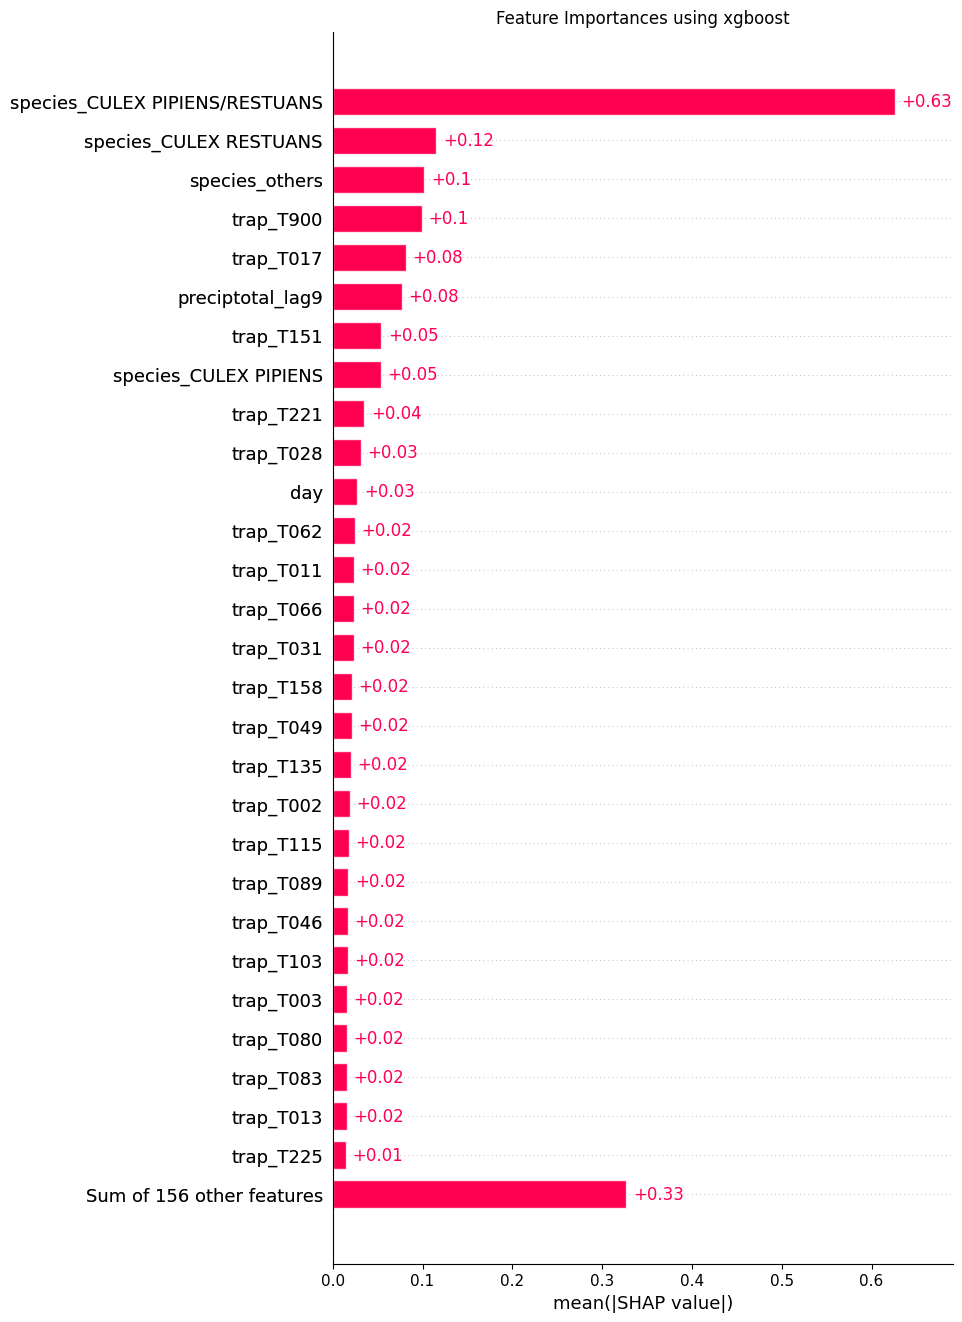

In [51]:
#Variable Importance Plot
plt.title('Feature Importances using xgboost')
shap.plots.bar(shap_values,
               max_display=29,
              )


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


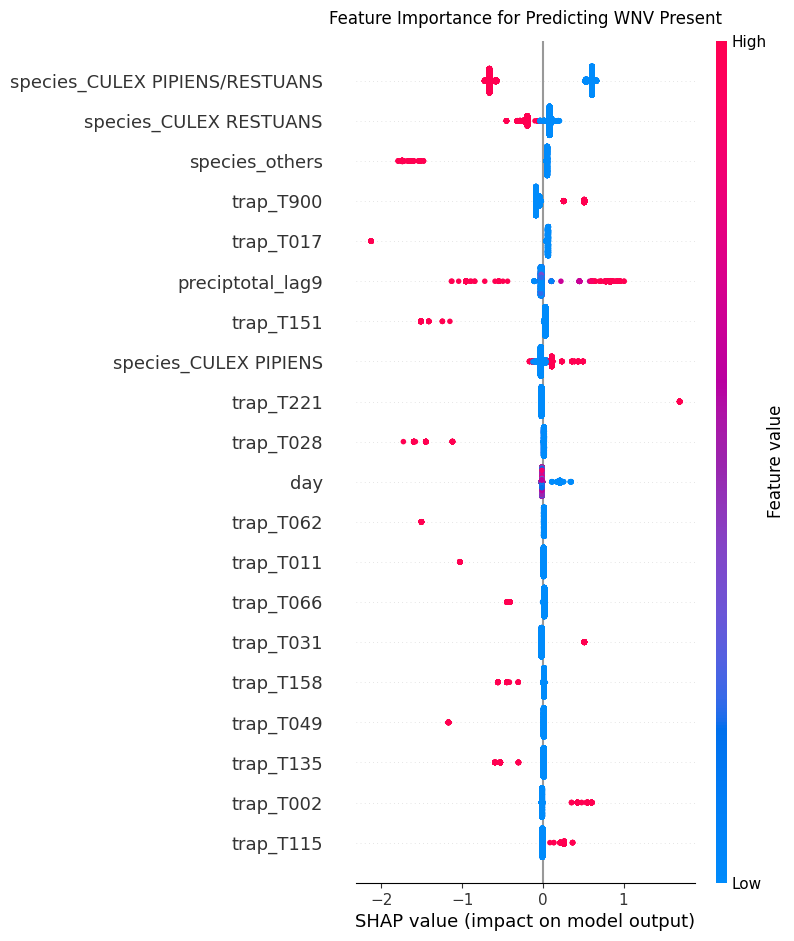

In [52]:
plt.title("Feature Importance for Predicting WNV Present", y=1.01)
shap.summary_plot(shap_values)

*Interpretation:*

The SHAP value Beeswarm plot above shows the features that have the highest impact on model prediction. 

In line with what we found in EDA, the species of the mosquito has the highest impact on model prediction.

Precipitation are rank quite highly in the feature importance. Of slightly more interest here is the 9-day-lagged day length feature. Culex mosquitos are typically night biters, so the length of day/night affects their activities. The shortest days have the largest impact on predicting for absence of WNV 9 days later, which appears contrary to mosquito activity. A possible explanation could be that since precipitation are associated with accelerated mosquito develpoment, biting rates, and the incubation of the disease within a mosquito, days of a certain length provide the optimal heating environment that keeps the temperature comfortable for mosquitoes throughout the night. Colder seasons where mosquitoes do not thrive are also associated with shorter days, so that might be another reason as well.

The presence of Culex Pipiens, one of the primary vectors of WNV transmission in the US, is unsurprisingly a strong predictor of the presence of WNV. Culex Restuans on the otherhand, is more indicative of a lack of WNV.

### Recommendations

1. Identify more precisely when mosquito season is about to pick up in Q3 of each year and remind citizens to keep up with their protective/preventive strategies.


2. Enhance on the ground surveillance for mosquito breeding grounds. As recommended to all states by the CDC, Chicago should also employ professionals to conduct inspections for mosquito breeding areas during the high season. This will help supplement adulticiding efforts.


3. Use the model as a preliminary guide in deciding spray areas. The model can be used to predict the possible presence of WNV based on weather and trap related observations to be collected by the surveillance team. This would guide efforts in identifying hotspots by narrowing down the search area

### Conclusion
To recap our problem statement, as part of DATA-SCIENCE we are aiming to develop a model that can accurately predict the presence of WNV based on weather and temporal features to help Chicago and the CDPH more efficiently allocate resources to effectively prevent transmission of this harmful virus.

A summary of key data analysis insights:

1. In general, the plots for 2007 and 2013 showed more sharp peaks and decline because WNV was more prevalent in these years as seen from the bar plot at the beginning of our analysis.

2. Temperature seems to play an important factor in the proliferation of WNV. Higher temperatures (>60 degrees fahrenheit) would contributes to higher prevalence of WNV and number of mosquitoes with WNV.

3. Lower average and resultant wind speed (<10 mph) contributes to higher number of mosquitoes and the prevalence of WNV.

4. Lower total precipitation (<1.0 inch) contributes to higher prevalence of WNV and number of mosquitoes with WNV.

5. Most importantly, areas around traps that were sprayed had lower incidence of WNV and number of mosquitoes.

Following exploratory data analysis, we proceeded to engineer some relevant features and built several models. Our XGBoost model was ultimately evaluated as the best performing for our purpose and was hence selected as the production model since it fulfilled both criteria outlined in the problem statement (Recall > 0.75 & better performance than baseline model). This selected model achieved a recall score of 0.93 on the hold-out test set with minimal data pre-processing required. 

Through a cost benefit analysis, we were able to deduce that the overall benefit brought through the implementation of a spray-based mosquito control program outweighs its costs by a large margin. The model we built is also able to help streamline these efforts by providing some guidance on potential hotspots and allowing for more precise prediction on the start of mosquito season. 

The project can be considered a success since the aims outlined at the start were achieved. We hope that our work will be used to inform important mosquito-control-related decisions and help the CDPH more efficiently allocate resources to effectively prevent transmission of this potentially deadly virus. Stay safe, Chicago.

*Model got a public score of 0.61 on Kaggle*

### Future Directions
1. Projected costs of WNV prevention may differ for different years. This means that the cost benefit analysis should be reviewed from time to time.


2. The current dataset used in analysis and model building only focuses on weather features and trap-based data. Additional data might be useful in increasing the predictive ability of the model. One such example would be observations regarding reports on dead birds since WNV incubates in birds.


3. Some of the findings in our project can be included in educational materials to help the general public understand conditions favourable to culex mosquito breeding and hence WNV propagation.


4. This project is explicitly focused on spraying programs. Research into other mosquito-control methods can be done to supplement these efforts.